In [2]:
import pandas as pd

default = pd.read_csv('credit_default.csv')
default = default.drop('Unnamed: 0', axis=1)

new_header = default.iloc[0]
default = default[1:]
default.columns = new_header

default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
default.columns.tolist()

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [4]:
import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings('ignore')

sm = StructureModel()

In [5]:
sm.add_edges_from([
    ('PAY_0', 'PAY_2'),
    ('PAY_2', 'PAY_3'),
    ('PAY_3', 'PAY_4'),
    ('PAY_4', 'PAY_5'),
    ('PAY_5', 'PAY_6'),
    ])

sm.add_edges_from([
    ('BILL_AMT1', 'PAY_AMT1'),
    ('BILL_AMT2', 'PAY_AMT2'),
    ('BILL_AMT3', 'PAY_AMT3'),
    ('BILL_AMT4', 'PAY_AMT4'),
    ('BILL_AMT5', 'PAY_AMT5'),
    ('BILL_AMT6', 'PAY_AMT6'),
    ])

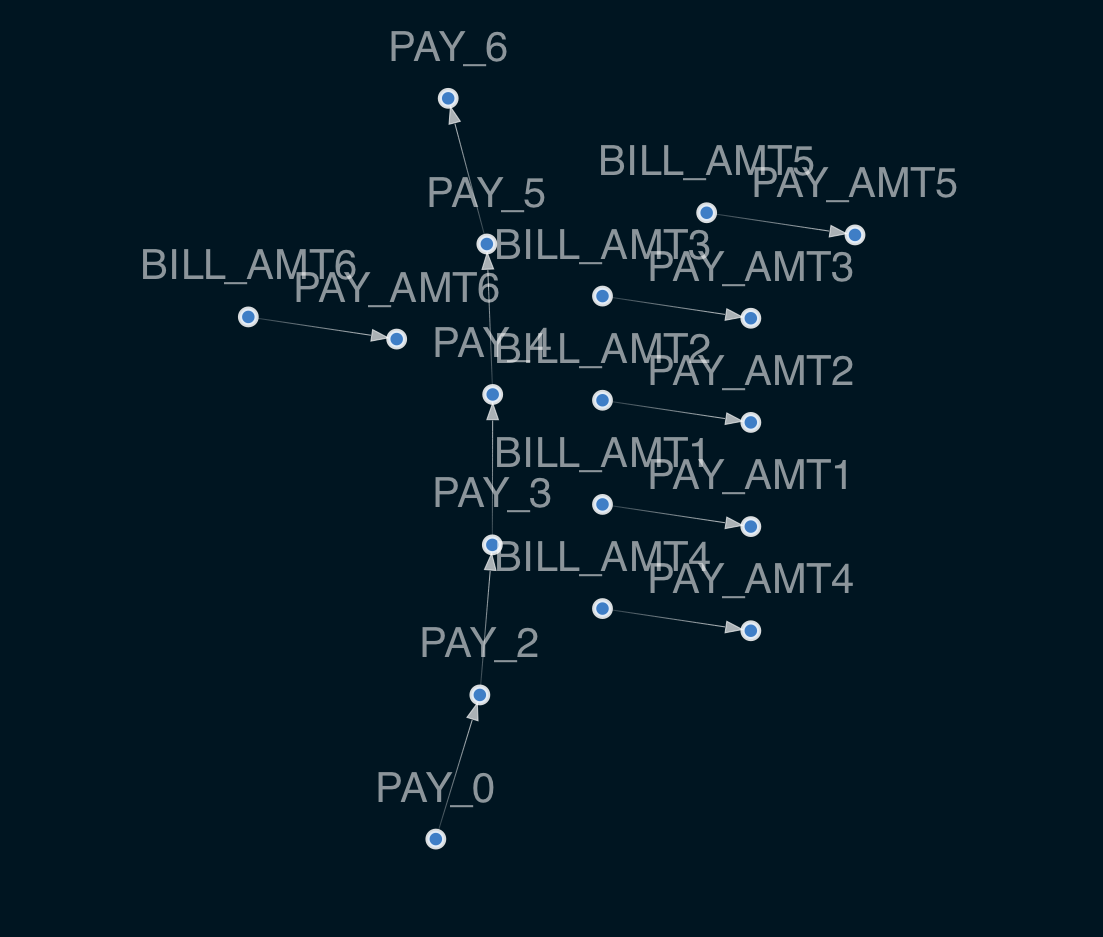

In [6]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format='png'))

In [7]:
default.dtypes

0
LIMIT_BAL                     object
SEX                           object
EDUCATION                     object
MARRIAGE                      object
AGE                           object
PAY_0                         object
PAY_2                         object
PAY_3                         object
PAY_4                         object
PAY_5                         object
PAY_6                         object
BILL_AMT1                     object
BILL_AMT2                     object
BILL_AMT3                     object
BILL_AMT4                     object
BILL_AMT5                     object
BILL_AMT6                     object
PAY_AMT1                      object
PAY_AMT2                      object
PAY_AMT3                      object
PAY_AMT4                      object
PAY_AMT5                      object
PAY_AMT6                      object
default payment next month    object
dtype: object

In [8]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# for column in default.columns.tolist():
#     default[column] = le.fit_transform(default[column])

In [9]:
# import seaborn as sns

# default['BILL_AMT1'] = pd.to_numeric(default['BILL_AMT1'])
# default['BILL_AMT2'] = pd.to_numeric(default['BILL_AMT2'])
# default['BILL_AMT3'] = pd.to_numeric(default['BILL_AMT3'])
# default['BILL_AMT4'] = pd.to_numeric(default['BILL_AMT4'])
# default['BILL_AMT5'] = pd.to_numeric(default['BILL_AMT5'])
# default['BILL_AMT6'] = pd.to_numeric(default['BILL_AMT6'])

# for i in [1,2,3,4,5,6]:
#     mini = min(default[f'BILL_AMT{i}'])
#     maxi = max(default[f'BILL_AMT{i}'])
    
#     print(mini, maxi)

In [10]:
import pandas_profiling

In [11]:
profile = pandas_profiling.ProfileReport(default)

In [12]:
profile

Summarize dataset:   8%|▊         | 41/520 [00:54<10:41,  1.34s/it, scatter BILL_AMT1, df_index]                


KeyboardInterrupt: 